## README
自定义Vit模型，受限于硬件、数据集及时间，只复现了模型架构、并做了少许训练，超参完全按照ViT paper中base模型设置

In [3]:

import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)

    return image_path

image_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi",
    remove_source=True,
)
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [4]:
from going_modular import data_setup, model_builder, engine, utils
from torchvision import transforms
import torch
from torch import nn
import torchvision
from torchinfo import summary
import matplotlib.pyplot as plt

DEVICE="cuda" if torch.cuda.is_available() else "cpu"
print(f"RUNNING ON {DEVICE} ")
BATCH_SIZE = 1024



# dataloader
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir="data/pizza_steak_sushi/train/",
    test_dir="data/pizza_steak_sushi/test/",
    train_transform=transform,
    test_transform=transform,
    batch_size=BATCH_SIZE
)

class_names

RUNNING ON cuda 


['pizza', 'steak', 'sushi']

In [5]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

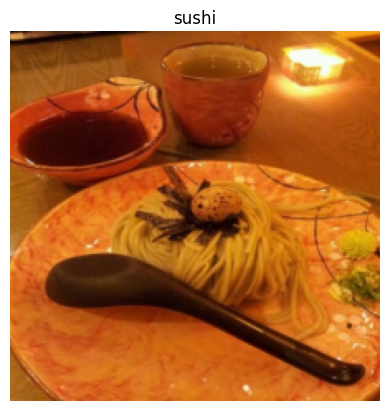

In [6]:
# test image is currect
image_permuted = image.permute(1,2,0)
plt.imshow(image_permuted)
plt.title(class_names[label])
plt.axis(False)

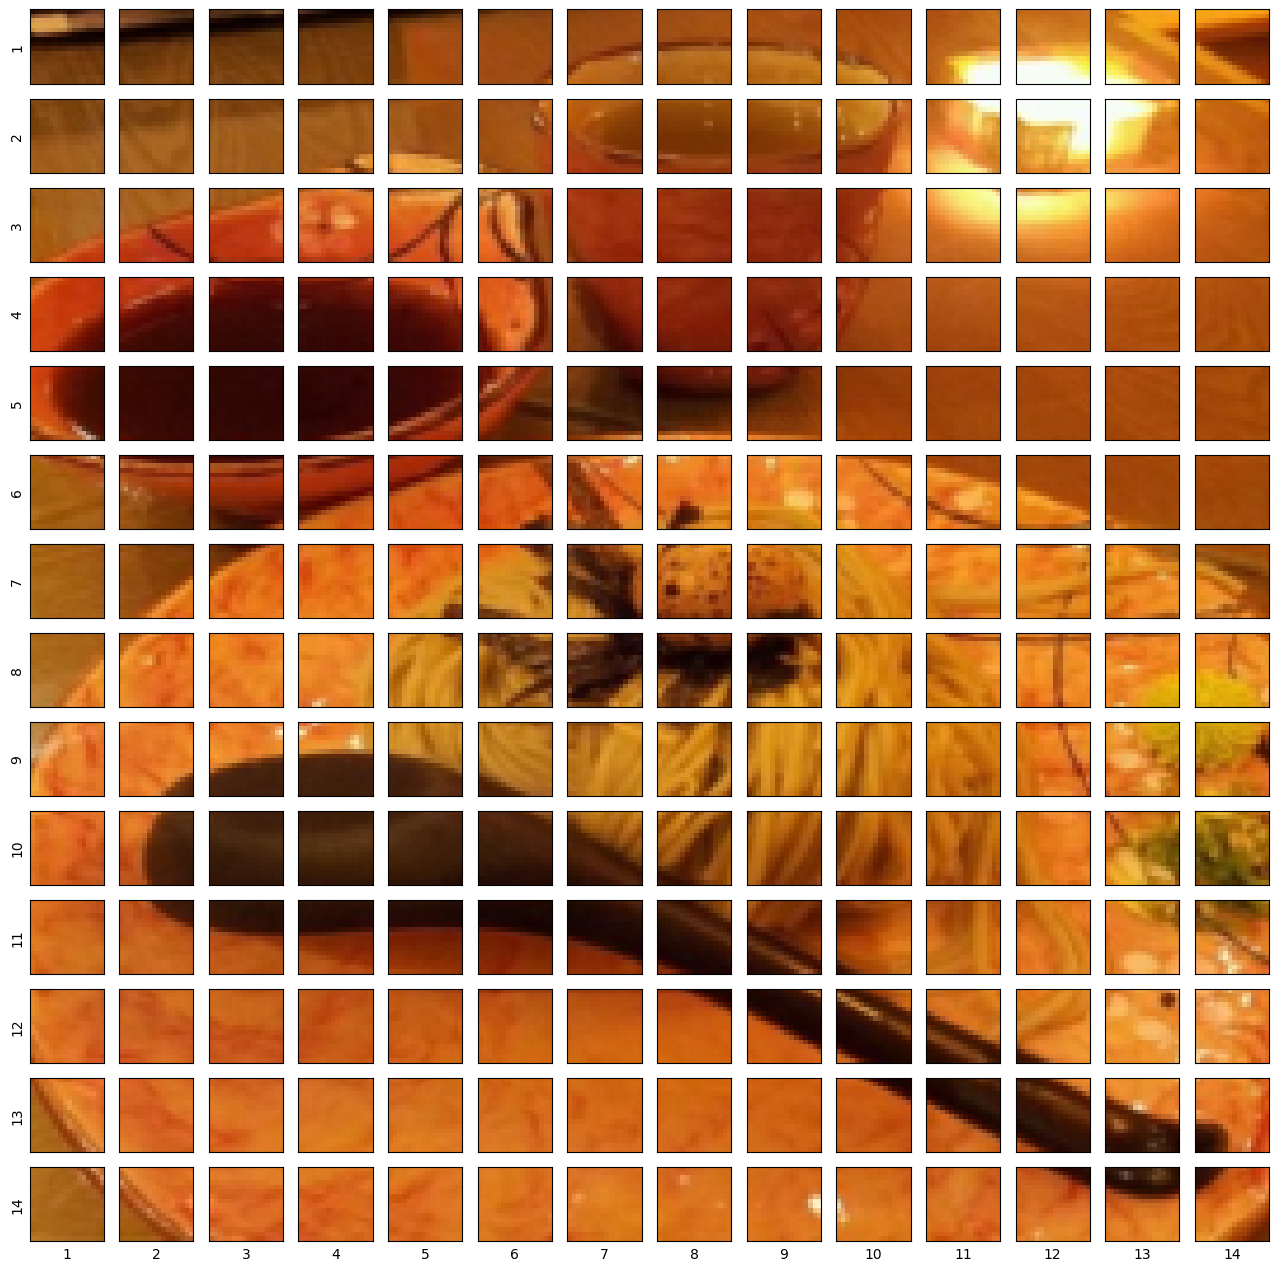

In [7]:
# define patches
image_size = 224
patch_size = 16
num_of_patches = image_size / patch_size
assert image_size % patch_size == 0, "Image size must be divisible by patch size"
# plot
fig, axs = plt.subplots(
    nrows=image_size // patch_size,
    ncols=image_size // patch_size,
    figsize=(patch_size, patch_size),
)

for idx_r, patch_height in enumerate(range(0, image_size, patch_size)):
    for idx_c, patch_width in enumerate(range(0, image_size, patch_size)):
        axs[idx_r, idx_c].imshow(
            image_permuted[
                patch_height : patch_height + patch_size,
                patch_width : patch_width + patch_size,
                :,
            ]
        )
        axs[idx_r, idx_c].set_xticks([])
        axs[idx_r, idx_c].set_yticks([])
        axs[idx_r, idx_c].set_ylabel(idx_r + 1)
        axs[idx_r, idx_c].set_xlabel(idx_c + 1)
        axs[idx_r, idx_c].label_outer()

In [8]:
# model define
model_vit = model_builder.ViT()

print(f"model name is [{model_vit.__class__.__name__}]")
summary(
    model=model_vit,
    input_size=(1, 3, 224, 224),  # (batch_size, num_patches, embedding_dimension)
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)


model name is [ViT]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 1000]            152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

In [9]:
# writer
writer = utils.create_summary_writer(
    experiment_name="VIT", model_name=model_vit.__class__.__name__
)

SummaryWriter Created, saving to : runs/2025-10-29/VIT/ViT...


In [ ]:
from going_modular import engine

LEARNING_RATE = 1e-4
EPOCHS=150

optimizer = torch.optim.Adam(
    params=model_vit.parameters(),
    lr=LEARNING_RATE,
    betas=(0.9, 0.999),
)
loss_fn = torch.nn.CrossEntropyLoss()

model_vit = torch.compile(model=model_vit)
results = engine.train(model=model_vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=EPOCHS,
                       device=DEVICE,
                       writer=writer)

  0%|          | 0/150 [00:00<?, ?it/s]

/home/nico/code/LLM-inference-basics/1-transformer-basic/vit/.venv/lib/python3.11/site-packages/torch/backends/cuda/__init__.py:131: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return torch._C._get_cublas_allow_tf32()
/home/nico/code/LLM-inference-basics/1-transformer-basic/vit/.venv/lib/python3.11/site-packages/torch/_inductor/compile_fx.py:312: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('hi

In [ ]:
# save model
from going_modular import prediction
prediction.plot_loss_curves(results)
utils.save_model(model=model_vit,target_dir="modelzoo",model_name="VitBaseTrainEnd2End.pth")